In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

import plotly as py
import plotly.graph_objs as go

import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing 
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
import sklearn.metrics

import time

# Kmeans Clustering

In [2]:
df = pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,1,1,19,15,39,3
1,2,1,21,15,81,4
2,3,0,20,16,6,3
3,4,0,23,16,77,4
4,5,0,31,17,40,3


In [3]:
df = df.drop(['cluster'],axis=1)

In [4]:
#find number of null entries to see if there is a need to clean the dataset
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [5]:
df.nunique()

CustomerID                200
Gender                      2
Age                        51
Annual Income (k$)         64
Spending Score (1-100)     84
dtype: int64

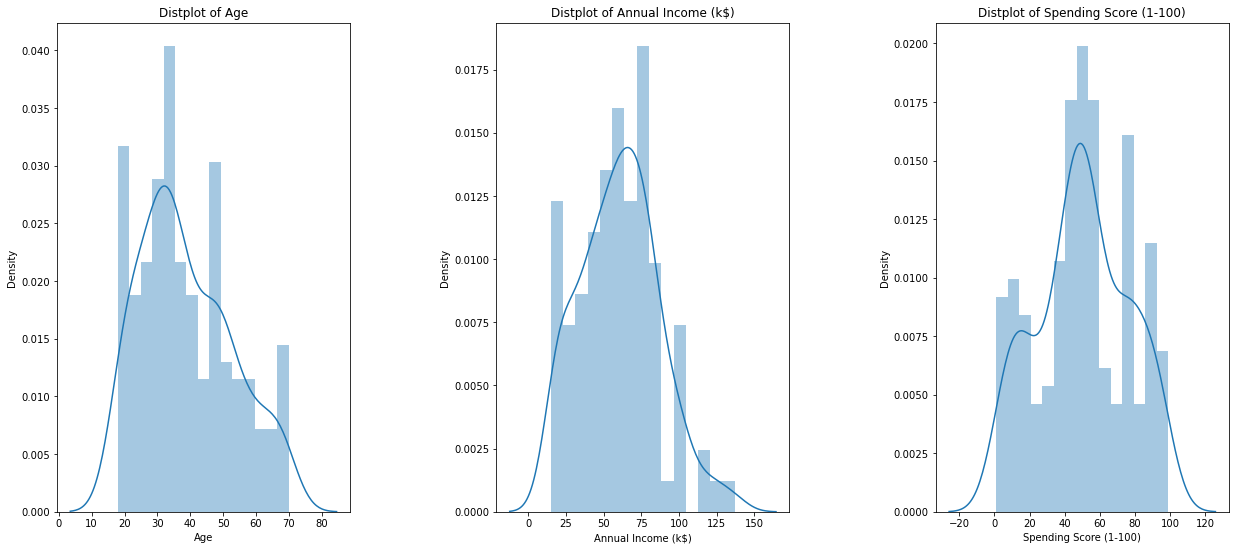

In [6]:
plt.figure(1 , figsize = (21 , 9))
n = 0 
for x in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(wspace = 0.5)
    sns.distplot(df[x] , bins = 15)
    plt.title('Distplot of {}'.format(x))
plt.show()

In [7]:
#convert gender - Male = 1, Female = 0
label_encoder = preprocessing.LabelEncoder() 
df['Gender'] = label_encoder.fit_transform(df['Gender'])

df2 = df.iloc[:, [1]]
df = df.drop(columns=['CustomerID'])
df

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40
...,...,...,...,...
195,0,35,120,79
196,0,45,126,28
197,1,32,126,74
198,1,32,137,18


In [8]:
df2

,Gender
0,1
1,1
2,0
3,0
4,0
...,...
195,0
196,0
197,1
198,1


In [9]:
df = df.drop(columns=['Gender'])
df

,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40
...,...,...,...
195,35,120,79
196,45,126,28
197,32,126,74
198,32,137,18


In [10]:
from sklearn.preprocessing import StandardScaler
scaled_features = StandardScaler().fit_transform(df.values)
scaled_features_df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)
for_visual = scaled_features_df.copy()
scaled_features_df

,Age,Annual Income (k$),Spending Score (1-100)
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980
...,...,...,...
195,-0.276302,2.268791,1.118061
196,0.441365,2.497807,-0.861839
197,-0.491602,2.497807,0.923953
198,-0.491602,2.917671,-1.250054


In [11]:
scaled_features_df = scaled_features_df.join(df2)
scaled_features_df

,Age,Annual Income (k$),Spending Score (1-100),Gender
0,-1.424569,-1.738999,-0.434801,1
1,-1.281035,-1.738999,1.195704,1
2,-1.352802,-1.700830,-1.715913,0
3,-1.137502,-1.700830,1.040418,0
4,-0.563369,-1.662660,-0.395980,0
...,...,...,...,...
195,-0.276302,2.268791,1.118061,0
196,0.441365,2.497807,-0.861839,0
197,-0.491602,2.497807,0.923953,1
198,-0.491602,2.917671,-1.250054,1


In [12]:
# import PCA
from sklearn.decomposition import PCA 
# Applying PCA to visualize data
pca = PCA(n_components = 2)
pca_data_visual = pd.DataFrame(pca.fit_transform(scaled_features_df),columns=['PC1','PC2']) 
pca_data = pca_data_visual.copy()
pca_data

,PC1,PC2
0,-0.600438,-1.737179
1,-1.649886,-1.789124
2,0.315381,-1.692772
3,-1.477989,-1.781317
4,-0.060545,-1.678691
...,...,...
195,-1.101819,2.201867
196,0.792047,2.517450
197,-1.089706,2.470818
198,0.425949,2.964343


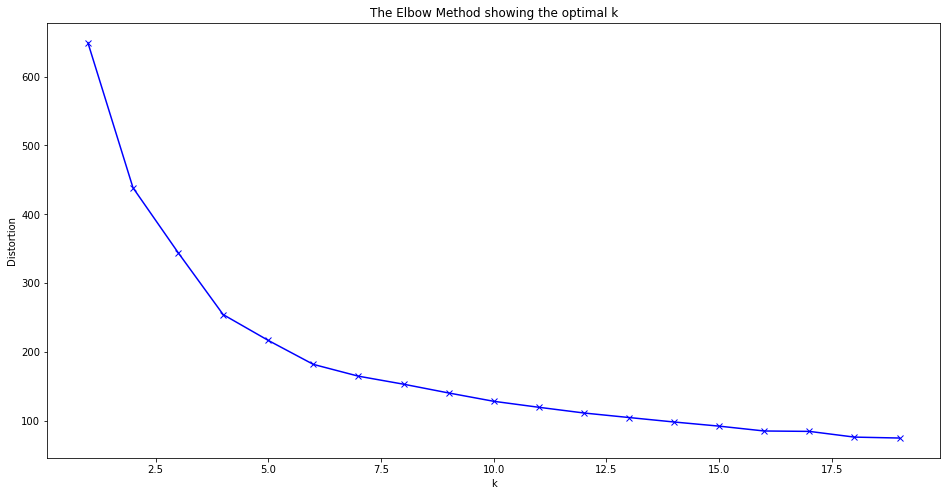

In [13]:
distortions = []
K = range(1,20)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(scaled_features_df)
    distortions.append(kmeans.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Uisng the elbow method we can see that the optimal number of clusters is **6**

In [14]:
num_clusters = 6

In [15]:
def kmeans_clustering(train_data, num_clusters):
    cluster_data = train_data.copy()
    kmeans = KMeans(n_clusters = num_clusters, random_state=42)
    kmeans.fit(train_data)
    #implement 3 other metrics here
    print('Davies Bouldin index: ', davies_bouldin(train_data, kmeans.labels_))
    print('Silhouetter Score: ', silhouette(train_data, kmeans.labels_))
    print('Calinski Harabasz Score: ', calinski_score(train_data, kmeans.labels_))

In [16]:
# train_data is the data we fit the clustering algorithm on (without the predict label and after all the cleaning, PCA, one_hot_encoding)
# predicted_clusters is the output we get from the clustering algorithm(eg:- kmeans.labels_)
# test_data is the predict label which we remove from the train_data

# train_data - DataFrame
# predicted_cluster - Series
# test_data - 

def davies_bouldin(train_data, predicted_clusters):
    from sklearn.metrics import davies_bouldin_score
    return(davies_bouldin_score(train_data, predicted_clusters))

def silhouette(train_data, predicted_clusters):
    from sklearn.metrics import silhouette_score
    score = silhouette_score(train_data, predicted_clusters, metric='euclidean')
    return score

def calinski_score(train_data, predicted_clusters):
    from sklearn.metrics import calinski_harabasz_score
    return(calinski_harabasz_score(train_data, predicted_clusters))
#Example
#classification_accuracy(clustering_data, kmeans.labels_, test_data)

## Using the scaled data for kmeans 

In [17]:
kmeans =KMeans(n_clusters=num_clusters,random_state=42).fit(for_visual)

In [18]:
kmeans_clustering(for_visual, num_clusters)

Davies Bouldin index:  0.8253539040983219
Silhouetter Score:  0.4284167762892593
Calinski Harabasz Score:  135.10210365783408


In [19]:
labels = kmeans.fit_predict(scaled_features_df)
scaled_features_df['cluster'] = pd.DataFrame(labels)
scaled_features_df['cluster'].value_counts()

0    45
1    39
2    38
4    34
5    23
3    21
Name: cluster, dtype: int64

## Using the pca data for kmeans and visualization 

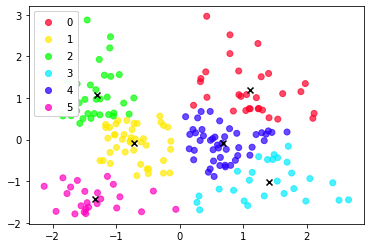

In [20]:
fig,ax = plt.subplots()
kmeans =KMeans(n_clusters=num_clusters,random_state=42).fit(pca_data)
pca_data_visual['cluster'] = pd.Categorical(kmeans.labels_)
scatter = ax.scatter(pca_data_visual['PC1'], pca_data_visual['PC2'],c=pca_data_visual['cluster'],cmap='gist_rainbow',alpha=0.7)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="")
centers = np.array(kmeans.cluster_centers_)
plt.scatter(centers[:,0], centers[:,1], marker="x", color='black')
ax.add_artist(legend1)

In [21]:
kmeans_clustering(pca_data, num_clusters)

Davies Bouldin index:  0.8583048472354914
Silhouetter Score:  0.37542015717044125
Calinski Harabasz Score:  183.40737997723812


In [22]:
labels = kmeans.fit_predict(pca_data)
pca_data['cluster'] = pd.DataFrame(labels)
pca_data['cluster'].value_counts()

4    46
1    42
2    31
0    30
3    27
5    24
Name: cluster, dtype: int64

# Kmeans++ Clustering

In [23]:
scaled_features = StandardScaler().fit_transform(df.values)
scaled_features_df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)
scaled_features_df

,Age,Annual Income (k$),Spending Score (1-100)
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980
...,...,...,...
195,-0.276302,2.268791,1.118061
196,0.441365,2.497807,-0.861839
197,-0.491602,2.497807,0.923953
198,-0.491602,2.917671,-1.250054


In [24]:
scaled_features_df = scaled_features_df.join(df2)
for_visual = scaled_features_df.copy()
scaled_features_df

,Age,Annual Income (k$),Spending Score (1-100),Gender
0,-1.424569,-1.738999,-0.434801,1
1,-1.281035,-1.738999,1.195704,1
2,-1.352802,-1.700830,-1.715913,0
3,-1.137502,-1.700830,1.040418,0
4,-0.563369,-1.662660,-0.395980,0
...,...,...,...,...
195,-0.276302,2.268791,1.118061,0
196,0.441365,2.497807,-0.861839,0
197,-0.491602,2.497807,0.923953,1
198,-0.491602,2.917671,-1.250054,1


In [25]:
pca = PCA(n_components = 2)
pca_data_visual = pd.DataFrame(pca.fit_transform(scaled_features_df),columns=['PC1','PC2']) 
pca_data = pca_data_visual.copy()
pca_data

,PC1,PC2
0,-0.600438,-1.737179
1,-1.649886,-1.789124
2,0.315381,-1.692772
3,-1.477989,-1.781317
4,-0.060545,-1.678691
...,...,...
195,-1.101819,2.201867
196,0.792047,2.517450
197,-1.089706,2.470818
198,0.425949,2.964343


In [26]:
def plus_plus(ds, k, random_state=42):
    np.random.seed(42)
    centroids = [ds[0]]

    for _ in range(1, k):
        dist_sq = np.array([min([np.inner(c-x,c-x) for c in centroids]) for x in ds])
        probs = dist_sq/dist_sq.sum()
        cumulative_probs = probs.cumsum()
        r = np.random.rand()
        
        for j, p in enumerate(cumulative_probs):
            if r < p:
                i = j
                break
        
        centroids.append(ds[i])

    return np.array(centroids)

In [27]:
ds_scaled = for_visual.to_numpy()

In [28]:
ds_pca = pca_data.to_numpy()

In [29]:
ds_scaled

array([[-1.42456879, -1.73899919, -0.43480148,  1.        ],
       [-1.28103541, -1.73899919,  1.19570407,  1.        ],
       [-1.3528021 , -1.70082976, -1.71591298,  0.        ],
       [-1.13750203, -1.70082976,  1.04041783,  0.        ],
       [-0.56336851, -1.66266033, -0.39597992,  0.        ],
       [-1.20926872, -1.66266033,  1.00159627,  0.        ],
       [-0.27630176, -1.62449091, -1.71591298,  0.        ],
       [-1.13750203, -1.62449091,  1.70038436,  0.        ],
       [ 1.80493225, -1.58632148, -1.83237767,  1.        ],
       [-0.6351352 , -1.58632148,  0.84631002,  0.        ],
       [ 2.02023231, -1.58632148, -1.4053405 ,  1.        ],
       [-0.27630176, -1.58632148,  1.89449216,  0.        ],
       [ 1.37433211, -1.54815205, -1.36651894,  0.        ],
       [-1.06573534, -1.54815205,  1.04041783,  0.        ],
       [-0.13276838, -1.54815205, -1.44416206,  1.        ],
       [-1.20926872, -1.54815205,  1.11806095,  1.        ],
       [-0.27630176, -1.

In [30]:
ds_pca

array([[-0.60043766, -1.73717898],
       [-1.64988591, -1.78912423],
       [ 0.31538132, -1.69277231],
       [-1.47798868, -1.78131664],
       [-0.06054496, -1.67869121],
       [-1.5029612 , -1.7438065 ],
       [ 1.07202103, -1.58773793],
       [-1.94718878, -1.72769057],
       [ 2.65927595, -1.4504641 ],
       [-0.99141027, -1.64691155],
       [ 2.50988817, -1.45931005],
       [-1.47785399, -1.67316678],
       [ 1.98742066, -1.47928386],
       [-1.43412929, -1.62698028],
       [ 1.01549562, -1.4775323 ],
       [-1.55292967, -1.59402762],
       [ 0.27232193, -1.5119479 ],
       [-1.2997754 , -1.54249961],
       [ 1.33203751, -1.35564719],
       [-1.45726454, -1.51942393],
       [ 0.30455257, -1.3581841 ],
       [-1.24333274, -1.42787781],
       [ 1.644869  , -1.29854428],
       [-0.94101737, -1.37824333],
       [ 1.79852122, -1.18081367],
       [-1.29406171, -1.27973079],
       [ 0.84929965, -1.22201945],
       [-0.41464999, -1.24030551],
       [ 0.6216485 ,

In [31]:
centroids_scaled = plus_plus(ds_scaled, num_clusters)

In [32]:
centroids_pca = plus_plus(ds_pca, num_clusters)

In [33]:
def kmeans_clustering_plus(train_data, num_centroids, num_clusters):
    cluster_data = train_data.copy()
    kmeans = KMeans(n_clusters = num_clusters, init = num_centroids, random_state=42)
    kmeans.fit(train_data)
    #implement 3 other metrics here
    print('Davies Bouldin index: ', davies_bouldin(train_data, kmeans.labels_))
    print('Silhouetter Score: ', silhouette(train_data, kmeans.labels_))
    print('Calinski Harabasz Score: ', calinski_score(train_data, kmeans.labels_))

## Using the scaled data for kmeans++ 

In [34]:
kmeans =KMeans(n_clusters=num_clusters, init = centroids_scaled ,random_state=42).fit(for_visual)

In [35]:
kmeans_clustering_plus(for_visual, centroids_scaled, num_clusters)

Davies Bouldin index:  1.009585613820308
Silhouetter Score:  0.3570196908083302
Calinski Harabasz Score:  99.44562479027839


In [36]:
labels = kmeans.fit_predict(scaled_features_df)
scaled_features_df['cluster'] = pd.DataFrame(labels)
scaled_features_df['cluster'].value_counts()

1    45
3    39
4    38
2    33
0    24
5    21
Name: cluster, dtype: int64

## Using the pca data for kmeans++ and visualization 

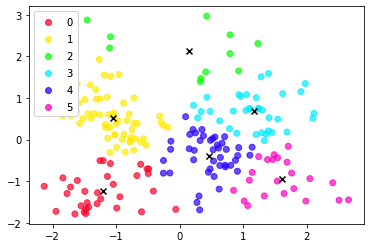

In [37]:
fig,ax = plt.subplots()
kmeans =KMeans(n_clusters=num_clusters, init = centroids_pca ,random_state=42).fit(pca_data)
pca_data_visual['cluster'] = pd.Categorical(kmeans.labels_)
scatter = ax.scatter(pca_data_visual['PC1'], pca_data_visual['PC2'],c=pca_data_visual['cluster'],cmap='gist_rainbow',alpha=0.7)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="")
centers = np.array(kmeans.cluster_centers_)
plt.scatter(centers[:,0], centers[:,1], marker="x", color='black')
ax.add_artist(legend1)

In [38]:
kmeans_clustering_plus(pca_data, centroids_pca, num_clusters)

Davies Bouldin index:  0.8134745738834285
Silhouetter Score:  0.4065471710817528
Calinski Harabasz Score:  171.1548055843313


In [39]:
labels = kmeans.fit_predict(pca_data)
pca_data['cluster'] = pd.DataFrame(labels)
pca_data['cluster'].value_counts()

1    57
4    43
3    35
0    32
5    22
2    11
Name: cluster, dtype: int64